In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import joblib

In [42]:
# Memuat dataset dari file
file_path = 'dataset.csv'
dataset = pd.read_csv(file_path)

# Menampilkan dataset asli
print("Dataset asli:")
print(dataset.head())


Dataset asli:
   Participant       EAR       MAR       MOE    Y
0          1.0  0.352255  0.998264  2.833928  0.0
1          1.0  0.324341  0.993003  3.061603  0.0
2          1.0  0.367728  0.999941  2.719243  0.0
3          1.0  0.326678  1.000042  3.061252  0.0
4          1.0  0.204691  0.975033  4.763446  0.0


In [43]:
# Normalisasi dataset (kecuali kolom 'Y')
dataset['Y'] = dataset['Y'].astype(int)
scaler = MinMaxScaler()
print("\n Dataset sebelum dilakukan normalisasi (kolom 'EAR','MAR','MOE'):")
print(dataset.head()[['EAR','MAR','MOE']])
normalized_data = scaler.fit_transform(dataset[['EAR', 'MAR', 'MOE']])

normalized_df = pd.DataFrame(normalized_data, columns=['EAR', 'MAR', 'MOE'])

# Menggabungkan kembali data yang dinormalisasi dengan kolom 'Y'
normalized_df['Y'] = dataset['Y']

# Menampilkan dataset setelah menambahkan kembali kolom 'Y'
print("\nDataset setelah normalisasi (kolom 'EAR', 'MAR', 'MOE'):")
print(normalized_df.head())


 Dataset sebelum dilakukan normalisasi (kolom 'EAR','MAR','MOE'):
        EAR       MAR       MOE
0  0.352255  0.998264  2.833928
1  0.324341  0.993003  3.061603
2  0.367728  0.999941  2.719243
3  0.326678  1.000042  3.061252
4  0.204691  0.975033  4.763446

Dataset setelah normalisasi (kolom 'EAR', 'MAR', 'MOE'):
        EAR       MAR       MOE  Y
0  0.546381  0.332282  0.064733  0
1  0.492339  0.313073  0.082701  0
2  0.576338  0.338405  0.055682  0
3  0.496863  0.338774  0.082673  0
4  0.260692  0.247457  0.217007  0


In [44]:
# Membuat urutan data untuk input LSTM dengan panjang urutan 5 (mewakili 5 detik)
SEQ_LENGTH = 5

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(normalized_df.values, SEQ_LENGTH)

# Menampilkan beberapa contoh urutan data (sequences)
print("\nContoh urutan data (X):")
print(X[:2])
print("\nContoh label (y):")
print(y[:2])



Contoh urutan data (X):
[[[0.54638101 0.3322821  0.06473324]
  [0.49233924 0.31307263 0.08270088]
  [0.57633776 0.3384051  0.05568247]
  [0.49686293 0.33877442 0.08267318]
  [0.26069153 0.24745747 0.21700723]]

 [[0.49233924 0.31307263 0.08270088]
  [0.57633776 0.3384051  0.05568247]
  [0.49686293 0.33877442 0.08267318]
  [0.26069153 0.24745747 0.21700723]
  [0.48828907 0.30449235 0.08369393]]]

Contoh label (y):
[0. 0.]


In [45]:
# Memisahkan data menjadi set pelatihan dan pengujian
split_ratio = 0.8
split = int(split_ratio * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [46]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [47]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100,random_state=42,min_samples_split=2,min_samples_leaf=1)
rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

In [48]:
kantuk_indices = np.where(y_test == 10)[0]
if len(kantuk_indices) >= 119:
    np.random.seed(42)  # Untuk reproducibility
    remove_indices = np.random.choice(kantuk_indices, 119, replace=False)
    remaining_indices = np.setdiff1d(np.arange(len(y_test)), remove_indices)
    X_test = X_test_flat[remaining_indices]
    y_test = y_test[remaining_indices]
else:
    print("Tidak cukup sampel dalam kelas kantuk untuk menghapus 119 sampel.")
    X_test = X_test_flat
    y_test = y_test

In [49]:
# Membuat prediksi dan evaluasi
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 61.04%


In [50]:
# Menghitung confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

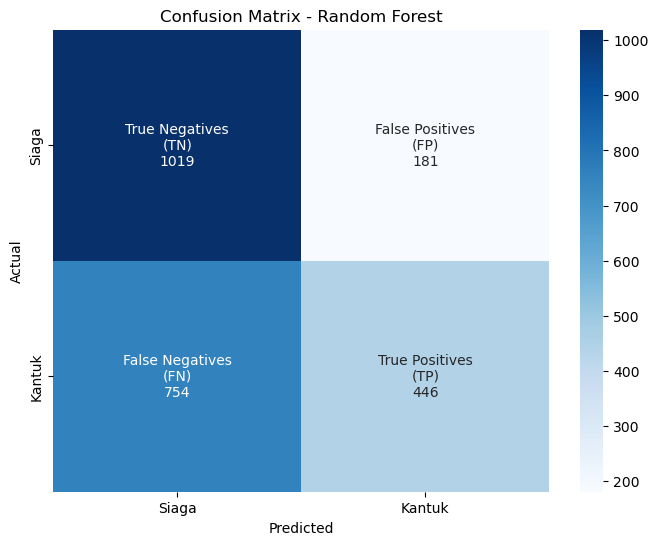

              precision    recall  f1-score   support

       Siaga       0.57      0.85      0.69      1200
      Kantuk       0.71      0.37      0.49      1200

    accuracy                           0.61      2400
   macro avg       0.64      0.61      0.59      2400
weighted avg       0.64      0.61      0.59      2400



In [51]:
# Buat label untuk confusion matrix
labels = np.array([['True Negatives\n(TN)', 'False Positives\n(FP)'],
                   ['False Negatives\n(FN)', 'True Positives\n(TP)']])

# Gabungkan label dan nilai ke dalam satu string untuk setiap sel
combined_labels = np.asarray([f'{label}\n{value}' for label, value in zip(labels.flatten(), cm_rf.flatten())]).reshape(2, 2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=combined_labels, fmt='', cmap='Blues', xticklabels=['Siaga', 'Kantuk'], yticklabels=['Siaga', 'Kantuk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Mencetak laporan klasifikasi
print(classification_report(y_test, y_pred_rf, target_names=['Siaga', 'Kantuk']))


In [52]:
# Mencetak laporan klasifikasi
print(classification_report(y_test, y_pred_rf, target_names=['Not Sleepy', 'Sleepy']))

              precision    recall  f1-score   support

  Not Sleepy       0.57      0.85      0.69      1200
      Sleepy       0.71      0.37      0.49      1200

    accuracy                           0.61      2400
   macro avg       0.64      0.61      0.59      2400
weighted avg       0.64      0.61      0.59      2400



In [53]:
# Menyimpan model Random Forest ke dalam file di PC
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_model, model_filename)
print(f"Model Random Forest disimpan sebagai {model_filename}")

Model Random Forest disimpan sebagai random_forest_model.pkl
